In this lab we will look at modeling an Ising system with Monte Carlo.
Most of the Python will be explained, but if you wanted practice, it can be found [here](https://www.learnpython.org/en/Basic_String_Operations). From the short turotials listed under Python basics, you are to be familiar with:
- Variables & Types
- Lists
- Basic Operators
- Conditions
- Loops
- Functions
- Classes & objects.

# Ising Model 

The Ising model is a lattice of $k$ interacting sites. Each site has a spin $\sigma_k$ which can have a value of +1 or -1. The spins are allowed to interact with their nearest-neighbor spins. The Hamiltonian for the system is given by:

$$
H(\sigma)=-\sum_{\langle i j\rangle} J_{i j} \sigma_{i} \sigma_{j}
$$

where $\langle i j\rangle$ indicate a sum over only nearest neighbors.
The interaction between spins is captured in $J$.
(If $J$, is positive the system will behave ferromagnetically while a negative $J$ favors antiferromagnetic interactions. (maybe this sentence will be better in the conclusions?))

We will start by introducing some code for this model. 

In [10]:
## think about umbrella sampling between points
## 1-D
## 2-D phase transitions. Given equations, but not derived in class. Expectd 1/2, but actual answer is 1/8th

To begin, we provide a python class for you to add your functions to. This will help keep variables organized. Initial functions have been provided to initialize your model, print the data, and plot the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class IsingModel:
    """
    Store attributes of an Ising lattice model
    Provide abstractions to conveniently manipulate lattice for simulations
    """
    def __init__(self, M, N, J, h=0):
        """
        Initialization.

        parameters:
            lattice is M by N sites
            M: size of first dimension
            N: size of second dimension
            J: interaction between neighbors (units: kT)
            h: background (external) field (units: kT)
        """
        # store parameters for convenience:
        #   energetic parameters
        self.J = J
        self.h = h

        #   size of lattice
        self.M = M
        self.N = N

        # We will store the lattice as an M by N array of -1 or 1
        # initialize each site as -1 or 1 with equal probability

        # The np.random.randint initializes random ints 
        # but does not include the high value so this initializes a 
        # matrix of -1 and 0's 
        lattice_state = np.random.randint(-1, high=1, size=(M, N))
        # then we change all the zeros to ones so we have a 
        # matrix of -1 and 1
        lattice_state[lattice_state == 0] = 1
        self.lattice_state = lattice_state
    
    def print_params(self):
        """
        Print lattice attributes
        """
        print("\t{:d} by {:d} lattice".format((self.M, self.N)))
        print("\tJ = {: 8.6f}   (positive means a favorable interaction)".format(self.J))
        print("\th = {: 8.6f}   (external field aligned with spins)".format(self.h))

    def plot_lattice(self):
        """
        Plot lattice configuration
        """
        plt.figure()

        imgplot = plt.imshow(self.lattice_state)
        imgplot.set_interpolation('none')

        plt.xticks(range(self.N))
        plt.yticks(range(self.M))

        for i in range(self.N+1):
            plt.plot([i-0.5, i-0.5], [0-0.5, self.M-0.5], color='black')
        for j in range(self.M+1):
            plt.plot([0-0.5, self.N-0.5], [j-0.5, j-0.5], color='black')

        plt.show()

In [3]:
 class IsingModel(IsingModel):
     def flip_spin(self, i, j):
        """
        Flip spin (i, j)
        i.e. -1 ---> 1
              1 ---> -1
        """
        self.lattice_state[i, j] = - self.lattice_state[i, j]

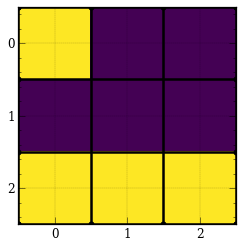

In [4]:
## Add simple test here to make sure they are interacting with class correctly. 
a = IsingModel(3, 3, 1.0, 0.0)
a.plot_lattice()

In [ ]:
# Describe periodic boundary conditions 

# expression for energy of a given lattice state

# Example on how to access the python object lattice_state

In [5]:
  class IsingModel(IsingModel):
    def calculate_energy_of_sites(self, i, j):
        """
        Calculate energy of spin (i, j)
        
        Periodic boundary conditions implemented
        """
        spin_here = self.lattice_state[i, j]  # value of spin here
        
        # value of spin above, below, left, and right of spin (i, j)
        # for each, if on boundary, we wrap around to the other side
        # of the lattice for periodic boundary conditions
        if j == 0:
            spin_above = self.lattice_state[i, self.N - 1]
        else:
            spin_above = self.lattice_state[i, j - 1]
        
        if j == self.N - 1:
            spin_below = self.lattice_state[i, 0]
        else:
            spin_below = self.lattice_state[i, j + 1]
            
        if i == self.M - 1:
            spin_right = self.lattice_state[0, j]
        else:
            spin_right = self.lattice_state[i + 1, j]
        
        if i == 0:
            spin_left = self.lattice_state[self.M - 1, j]
        else:
            spin_left = self.lattice_state[i - 1, j]
        
        return - self.h * spin_here - self.J * spin_here *\
            (spin_above + spin_below + spin_left + spin_right)

In [6]:
## add test here for correct behavior

In [ ]:
# desribe what we want from them here in the next code block

In [7]:
  class IsingModel(IsingModel):
    def calculate_lattice_energy_per_spin(self):
        """
        Calculate energy of lattice normalized by the number of spins
        """
        E = 0.0
        for i in range(self.M):
            for j in range(self.N):
                E += self.calculate_energy_of_spin(i, j)
        # factor of two for overcounting neighboring interactions.
        # but then need to add back -1/2 h \sum s_i 
        return E / 2.0 / (self.M * self.N) -\
            self.h * np.sum(self.lattice_state) / 2.0 / (self.M * self.N)

In [ ]:
# test code here

# Monte Carlo Simulations

Theoretically, we have made a very simple model for describing interacting systems. 
Additionally, we can now start to use this model for predicting observables. 
For example, for the expectation value of the energy of an $M*N$ lattice, the expectation value would be

$$
\langle E\rangle=\sum_{\alpha} E(\alpha) P(\alpha)
$$

where $E(\alpha)$ is the energy of a fixed state $\alpha$, and  $P(\alpha)$ is the probability of being in that fixed state.
However, the number of fixed states grows as $2^{(N*M)}$ where $N*M$ is the total number of lattice points.
This quickly becomes impractical as the lattice size grows.

To deal with this, we use Monte Carlo sampling to sample states $\alpha$ with probability $P(\alpha)$.

In [ ]:
# Initialize class
class Calculation:
    def __init__(self, ising_model, kT=1, num_equil_sweeps=1000, num_sweeps=1000):
        """
        Initializing
        """
        self.num_equil_sweeps = num_equil_sweeps
        self.num_sweeps = num_sweeps
        self.kT = kT
        self.ising_model = ising_model
        self.energies_list = []
        self.total_spin_list = []

In [ ]:
  class Calculation(Calculation):


# Applications of the class

1) Run an Ising model simulation with the following parameters:

Again, we initialize the python class as: `our_model = IsingModel(n, m, J, h)`

- finite size effects: studying two different lattice sizes
    - what differences do you notice at 10x10 and 30x30
- finding the transition temperature
    - distributions of spins above and below
- Standard deviation changes around phase transitions
- with and without magnetic field

#References:

code: 
    
theory: https://arxiv.org/pdf/0803.0217.pdf